# ***Final Project***
---

# 소프트웨어 융합 전공 2011218 이채림
# IT공학과 2214224 서지은
# 기계시스템학부 2316438 임채연

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Data augmentation and normalization for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.RandomRotation(15), #Random Rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),  # Fixed size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Train dataset with augmentation
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split trainset into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Validation dataset (using test transformations)
valset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
val_subset.dataset = valset  # Update transform for validation subset

# DataLoaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


100%|██████████| 170498071/170498071 [00:03<00:00, 46070210.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


truck   dog  bird plane


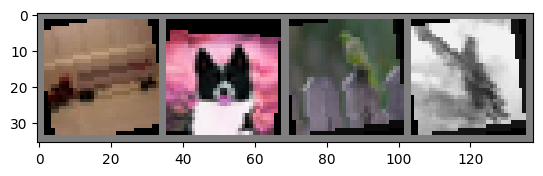

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5

  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module): #Batch Normalization과 dropout 사용
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 32x32 -> 16x16
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 16x16 -> 8x8
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))  # 8x8 -> 4x4
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout 사용
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleNet().to(device)

In [ ]:
!pip install torchsummary
from torchsummary import summary

summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 256, 16, 16]         295,168
       BatchNorm2d-9          [-1, 256, 16, 16]             512
        MaxPool2d-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]         590,080
      BatchNorm2d-14            [-1, 25

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #Weight Decay사용
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.00001)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
import matplotlib.pyplot as plt

# Set the number of epochs
epochs = 100

# Arrays to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    loss_tmp = 0.0
    epoch_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.item()
        epoch_loss += loss.item()

        if i % 5000 == 4999:  # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i + 1)))
            loss_tmp = 0.0

    # Calculate the average training loss for the epoch
    avg_train_loss = epoch_loss / (i + 1)
    train_losses.append(avg_train_loss)

    # Validation phase
    val_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valloader)
    val_losses.append(avg_val_loss)

    # Update the learning rate according to the learning rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Train Loss: %.3f, Val Loss: %.3f' % (epoch + 1, avg_train_loss, avg_val_loss))

print('Finished Training')



[Epoch - 1, Iteration -  5000] Loss: 1.943
[Epoch - 1, Iteration - 10000] Loss: 0.841
[Epoch - 1] Train Loss: 1.813, Val Loss: 1.359
[Epoch - 2, Iteration -  5000] Loss: 1.510
[Epoch - 2, Iteration - 10000] Loss: 0.700
[Epoch - 2] Train Loss: 1.455, Val Loss: 1.060
[Epoch - 3, Iteration -  5000] Loss: 1.285
[Epoch - 3, Iteration - 10000] Loss: 0.617
[Epoch - 3] Train Loss: 1.260, Val Loss: 0.924
[Epoch - 4, Iteration -  5000] Loss: 1.149
[Epoch - 4, Iteration - 10000] Loss: 0.552
[Epoch - 4] Train Loss: 1.126, Val Loss: 0.811
[Epoch - 5, Iteration -  5000] Loss: 1.047
[Epoch - 5, Iteration - 10000] Loss: 0.502
[Epoch - 5] Train Loss: 1.026, Val Loss: 0.782
[Epoch - 6, Iteration -  5000] Loss: 0.940
[Epoch - 6, Iteration - 10000] Loss: 0.458
[Epoch - 6] Train Loss: 0.929, Val Loss: 0.714
[Epoch - 7, Iteration -  5000] Loss: 0.862
[Epoch - 7, Iteration - 10000] Loss: 0.419
[Epoch - 7] Train Loss: 0.850, Val Loss: 0.634
[Epoch - 8, Iteration -  5000] Loss: 0.798
[Epoch - 8, Iteration - 10

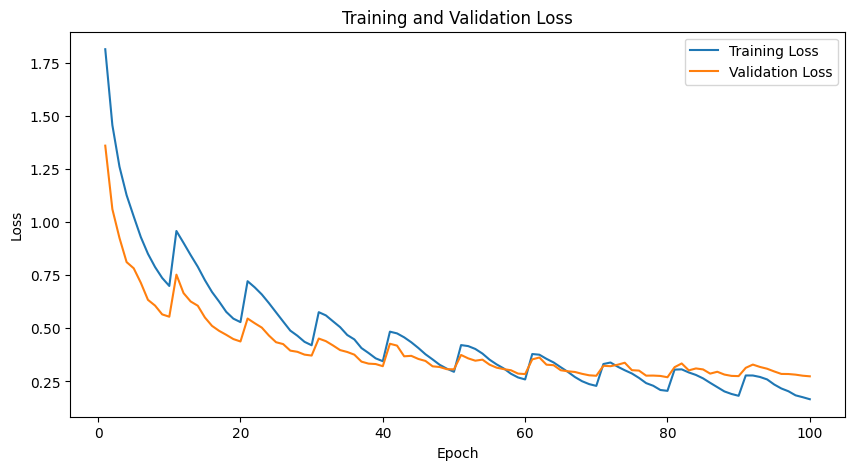

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


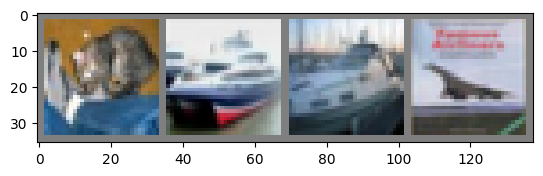

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset
net.eval()
correct = 0
total = 0

for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10,000 test images: 90 %
